In [23]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import random
from dataset import CoraData
from model import GCN

In [24]:
def seed_torch(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [25]:
# hyper params
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 50
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)
Data = namedtuple(
    'Data', ['x', 'y', 'adjacency', 'train_mask', 'val_mask', 'test_mask']) # 返回的是tuple的子类

cuda:0


In [26]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData('../../GCN/Cora').data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = torch.from_numpy(node_feature).to(DEVICE)  # (2708,1433)
tensor_y = torch.from_numpy(dataset.y).to(DEVICE)  # (2708)
tensor_train_mask = torch.from_numpy(dataset.train_mask).to(DEVICE)  # (2708)
tensor_val_mask = torch.from_numpy(dataset.val_mask).to(DEVICE)  # (2708)
tensor_test_mask = torch.from_numpy(dataset.test_mask).to(DEVICE)  # (2708)
normalize_adjacency = CoraData.normalization(
    dataset.adjacency)  # 规范化邻接矩阵，得到拉普拉斯矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(
    np.asarray([normalize_adjacency.row,
                normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices,
                                            values, (num_nodes, num_nodes)).to(
                                                DEVICE)  # (2708,2708)

Using Cached file: ../../GCN/Cora/processed_cora.pkl


In [27]:
# 模型定义：Model, Loss, Optimizer
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DACAY)

In [28]:
def train():
    model.train()
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []
    val_loss_history = []
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]  # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)  # 计算损失值
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc, _, _, train_loss = test(tensor_train_mask, tensor_y)
        val_acc, _, _, val_loss = test(tensor_val_mask, tensor_y)
        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        print(
            "epoch {:03d}: training loss {:.4f}, training acc {:.4}, validation acc {:.4f}"
            .format(epoch, loss.item(), train_acc.item(), val_acc.item()))
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [29]:
def test(mask, y):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        loss = criterion(test_mask_logits, y[mask])
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu(
    ).numpy(), loss

In [30]:
def plot_loss_with_acc(train_loss_history, train_acc_history, val_loss_history,
                       val_acc_history):
    train_acc_history=[item.cpu().numpy() for item in train_acc_history]
    val_loss_history=[item.cpu().numpy() for item in val_loss_history]
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_loss_history)),
             train_loss_history,
             c=np.array([255, 71, 90]) / 255.,
             label='training loss')
    plt.plot(range(len(val_loss_history)),
             val_loss_history,
             c=np.array([120, 80, 90]) / 255.,
             label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.title('loss')
    plt.savefig("../assets/loss.png")
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_acc_history)),
             train_acc_history,
             c=np.array([255, 71, 90]) / 255.,
             label='training acc')
    plt.plot(range(len(val_acc_history)),
             val_acc_history,
             c=np.array([120, 80, 90]) / 255.,
             label='validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.title('accuracy')
    plt.savefig("../assets/acc.png")
    plt.show()


epoch 000: training loss 1.9460, training acc 0.1429, validation acc 0.1140
epoch 001: training loss 1.9460, training acc 0.1429, validation acc 0.0580
epoch 002: training loss 1.9460, training acc 0.1429, validation acc 0.0580
epoch 003: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 004: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 005: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 006: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 007: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 008: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 009: training loss 1.9461, training acc 0.1429, validation acc 0.3160
epoch 010: training loss 1.9460, training acc 0.1429, validation acc 0.3160
epoch 011: training loss 1.9460, training acc 0.1429, validation acc 0.3160
epoch 012: training loss 1.9460, training acc 0.1429, validation acc 0.3160
epoch 013: t

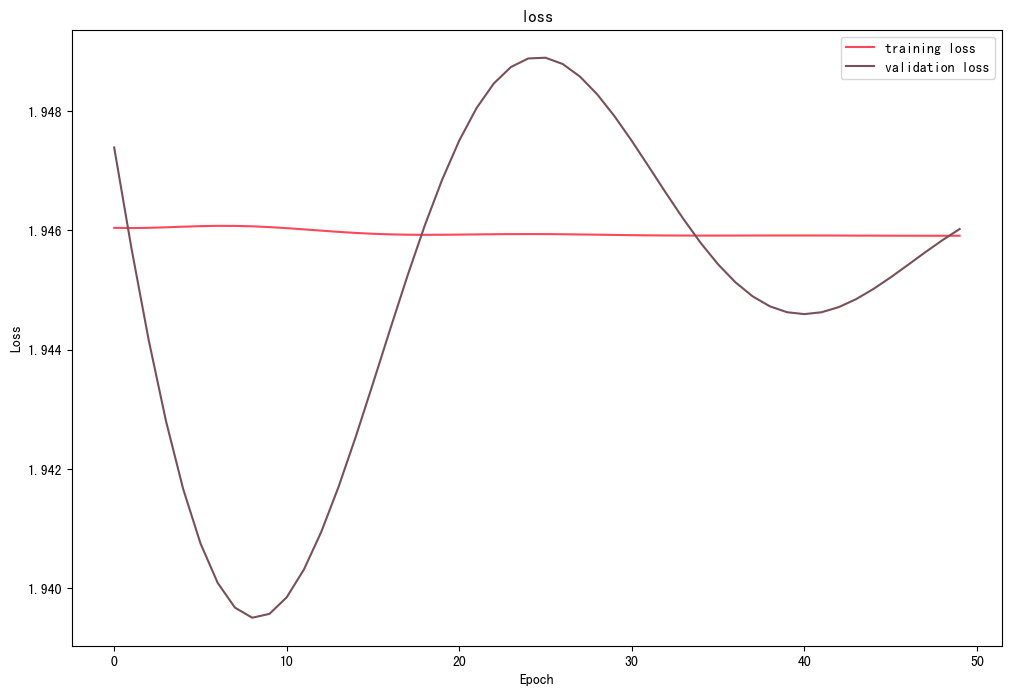

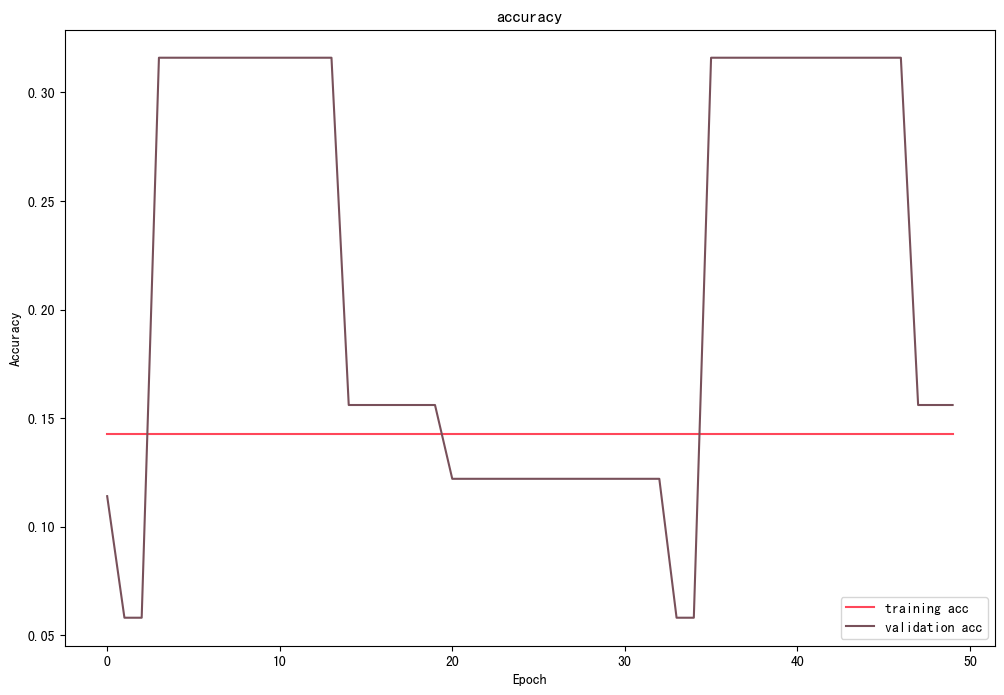

In [33]:
train_loss, train_acc, val_loss, val_acc = train()
test_acc, test_logits, test_label, _ = test(tensor_test_mask, tensor_y)
print("Test accuarcy: ", test_acc.item())
# print(type(train_loss))
# print(type(train_acc))
# print(type(val_loss))
# print(type(val_acc))
plot_loss_with_acc(train_loss, train_acc, val_loss, val_acc)

/home/zhoujianping/miniconda3/envs/torch3090/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhoujianping/miniconda3/envs/torch3090/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


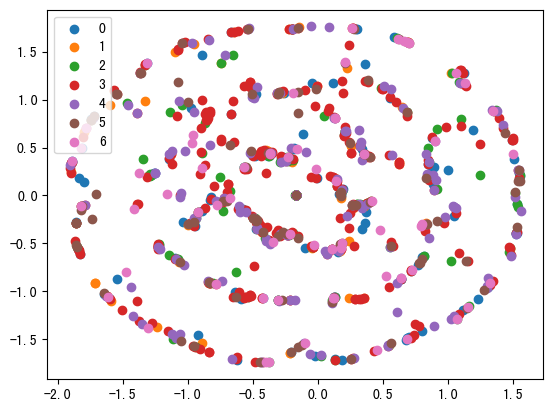

In [32]:
# tsne visualize
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend(loc=0)
plt.savefig('../assets/tsne.png')
plt.show()